# Adjust global gridded demographic data to each year by making the country levels totals match the UN WPP data


At the moment I have gridded demographics for 2010, but i want them from 1980-2020+ 

Originally, I had just projected yearly country-level demographic data to the grid and thereby have it for all years. Since GPWv4 added demographic data, it made sense to use that, but then i only have 2010 numbers.

I want a hybrid approach, where i assume a fixed spatial distribution of demographics but somehow adjust the proportions between each age band at the country level - essentially re-weighting the intra-country demographics such that the total demographics match the WPP country totals, while the spatial distribution is derived from the existing one.


## Method

simplest is to work with population totals per age band. Simply calculate the difference per country between the total per band in 2010 and the total for the given year from UN WPP, then divide by the number of cells in the country and add/subtract that value from each cell (assume the difference is evenly distributed.

For each year, calculate the adjusted demographic fractions by multiplying for each country the grid cells by the ratio of the demographic fractions for that year over the demographic fractions for 2010.

Proof (age band 65, years =10 and arbitrary year y, grid cell i)

$$
f^{10}_{65} = \Sigma f^{10}_{i,65} / N\\
f^{y}_{65} = \Sigma f^{y}_{i,65} / N
$$

$$
f^{y}_{65} = \delta^{y}_{65} f^{10}_{65}\\
\delta^{y}_{65}  = f^{y}_{65} / f^{10}_{65}
$$

$$
f^{y}_{65} = \Sigma f^{y}_{i,65} / N = \delta^{y}_{65} f^{10}_{65} = \delta^{y}_{65} \Sigma f^{10}_{i,65} / N = \Sigma \delta^{y}_{65} f^{10}_{i,65} / N 
$$


Therefore we can calculate each grid cell value for year *y* as

$$
f^{y}_{i,65} = \delta^{y}_{65} f^{10}_{i,65}
$$




$$
\delta^{y}_{age}  = f^{y}_{age} / f^{10}_{age}
$$


$$
f^{y}_{i,age} = \delta^{y}_{age} f^{10}_{i,age}
$$

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook, tqdm

from config import POP_DATA_SRC, DATA_SRC

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

In [2]:
UN_DEMOGRAPHICS_FILE  = POP_DATA_SRC / 'UN' / 'WPP2019_PopulationByAgeSex_Medium.csv'
    
COUNTRY_ID_LOOKUP = DATA_SRC/ 'lancet/population/gpwv4/gpw-v4-basic-demographic-characteristics-rev11_bt_cntm_15_min_nc/gpw_v4_national_identifier_grid_rev11_lookup.txt'


In [3]:
GPW_DATA_FILE= DATA_SRC/ 'lancet/population/UN WPP-Adjusted Population Count v4.11 2000-2020 15min era compat.nc'

In [4]:
GPW_DATA = xr.open_dataset(GPW_DATA_FILE).load()

COUNTRIES_LOOKUP = pd.read_csv(COUNTRY_ID_LOOKUP,sep='\t')

In [5]:
COUNTRIES_LOOKUP.head()

Value ISOCODE  UNSDCODE           NAME0  CIESINCODE  \
0      4     AFG         4     Afghanistan           4   
1      8     ALB         8         Albania           8   
2     12     DZA        12         Algeria          12   
3     16     ASM        16  American Samoa          16   
4     20     AND        20         Andorra          20   

                         DATATYPE  DATACODE  DATAYEAR  DATALEVEL  SEXLEVEL  \
0  Population estimate/projection         6      2011          2         2   
1                    Final census         1      2011          3         1   
2                    Final census         1      2008          2         2   
3                    Final census         1      2010          3         3   
4             Population register         5      2010          1         1   

   AGELEVEL  GRSTART  GREND  GRLEVEL  LASTCENSUS    MEANUNITKM  
0         0     1998   2011        1        1979   4507.466751  
1         1     2001   2011        3        2011    115.949835  
2         2     1998   2008        2        2008  50884.794880  
3         3     2000   2010        3        2010      7.612468  
4         1     2000   2010        1        2011     79.902822

In [6]:
un_demog = pd.read_csv(UN_DEMOGRAPHICS_FILE)

In [8]:
# No need to keep data all the way to 2100!
un_demog = un_demog[un_demog.Time < 2050]

In [9]:
un_demog.head()

LocID     Location  VarID Variant  Time  MidPeriod AgeGrp  AgeGrpStart  \
0      4  Afghanistan      2  Medium  1950     1950.5    0-4            0   
1      4  Afghanistan      2  Medium  1950     1950.5    5-9            5   
2      4  Afghanistan      2  Medium  1950     1950.5  10-14           10   
3      4  Afghanistan      2  Medium  1950     1950.5  15-19           15   
4      4  Afghanistan      2  Medium  1950     1950.5  20-24           20   

   AgeGrpSpan  PopMale  PopFemale  PopTotal  
0           5  630.044    661.578  1291.622  
1           5  516.206    487.335  1003.540  
2           5  461.378    423.326   884.704  
3           5  414.369    369.363   783.732  
4           5  374.109    318.392   692.501

In [10]:
population = GPW_DATA['UN WPP-Adjusted Population Count, v4.11 (2000-2020)']

In [11]:
demog = GPW_DATA['Basic Demographic Characteristics, v4.11 (2010): Both, Count']

In [12]:
demog_pcts = GPW_DATA['Basic Demographic Characteristics, v4.11 (2010): Both, Percent']

In [13]:
countries_grid = GPW_DATA['National Identifier Grid, v4.11 (2010): National Identifier Grid']

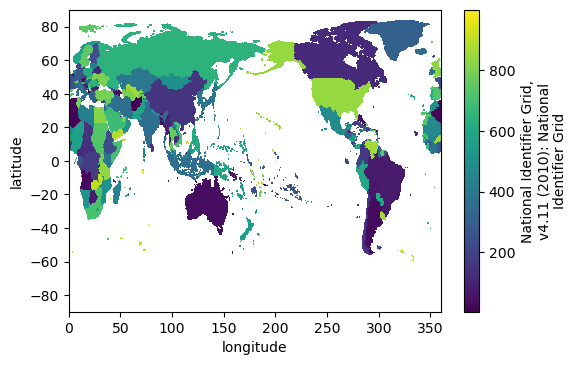

In [14]:
countries_grid.where(countries_grid < 3000 ).plot()

## Create an xarray ND dataset out of the table

In [15]:
un_demog_xr = un_demog[['LocID', 'Time', 'AgeGrpStart',  'PopTotal']].set_index(['AgeGrpStart','LocID', 'Time']).sort_index().to_xarray()

# Sum the values above age 65 and assign to the age 65 band
un_demog_xr.PopTotal.loc[dict(AgeGrpStart=65)] = un_demog_xr.PopTotal.sel(AgeGrpStart=slice(65, None)).sum(dim='AgeGrpStart')
# Drop the age bands above 65
un_demog_xr = un_demog_xr.sel(AgeGrpStart=slice(65))
un_demog_xr = un_demog_xr.rename({'AgeGrpStart': 'age_band_lower_bound', 'Time': 'year'})

## Convert all values to fractions of total population

In [16]:
un_demog_pct_xr = un_demog_xr.PopTotal / un_demog_xr.PopTotal.sum(dim='age_band_lower_bound')

## Get the ratios $\delta$

> NOTE: I think here the ratios should be calculated using the GRIDDED 2010 values as a basis, rather than the 'internal' ones, so that the resulting fractions are consistent with the grid -> at the moment we end up with deviations which means the output percentages don't add up to exactly 100 (max is about 120)

In [20]:
un_demog_pct_ratios = un_demog_pct_xr / un_demog_pct_xr.sel(year=2010)

## Prepare a results dataset with all the coordinates (space, time, age band)

In [26]:
results = xr.DataArray(
    np.zeros((
        len(demog_pcts.age_band_lower_bound), 
        len(demog_pcts.latitude), 
        len(demog_pcts.longitude), 
        len(un_demog_pct_ratios.year))), 
    coords=[
        demog_pcts.age_band_lower_bound,
        demog_pcts.latitude,
        demog_pcts.longitude, 
        un_demog_pct_ratios.year
    ]
)

In [32]:
for _, row in tqdm(COUNTRIES_LOOKUP.iterrows(), total=len(COUNTRIES_LOOKUP)):
    if row.UNSDCODE in un_demog_pct_ratios.LocID:
        grid_code = row.CIESINCODE
        country_mask = countries_grid == grid_code
        # Get the 'base' demographic grid for 2010
        country_demog_2010 = demog_pcts.where(country_mask)
        # Get the time series of demographics per country
        country_demog_all_years = un_demog_pct_xr.sel(LocID=row.UNSDCODE).drop('LocID')
        
        country_ratios = un_demog_pct_ratios.sel(LocID=row.UNSDCODE).drop('LocID')
        
        # Calculate the gridded value by adjusting the 2010 grid using the ratio above
        country_demog = country_ratios * country_demog_2010
        results = xr.where(country_mask, country_demog, results)
        

100%|██████████| 248/248 [32:51<00:00,  7.95s/it]


## Finalise results - replace any missing values by ones from the 2010 data (NOTE could make for some weird artefacts... maybe better to use an average or something?)

In [33]:
results = xr.where(((results < 0.0001) & (demog_pcts > 0)), demog_pcts, results).where(np.isfinite(demog_pcts))

In [18]:
# Force the sum of fractions to =1
# results = results / results.sum(dim='age_band_lower_bound')

In [34]:
check = results.sum(dim='age_band_lower_bound')
check = check.where(check > 0)

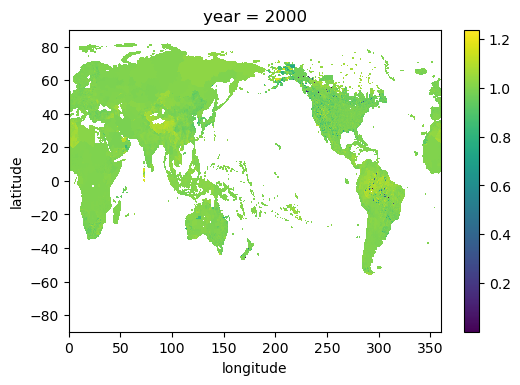

In [35]:
check.sel(year=2000).plot()

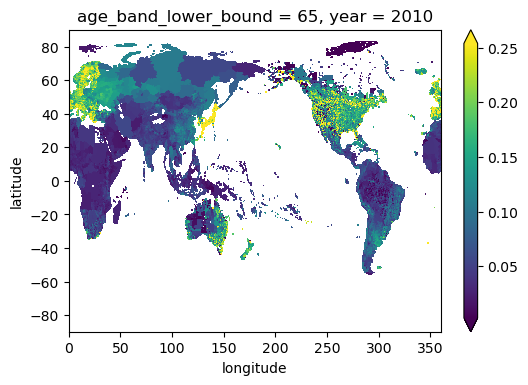

In [37]:
results.sel(age_band_lower_bound=65, year=2010).plot(robust=True)

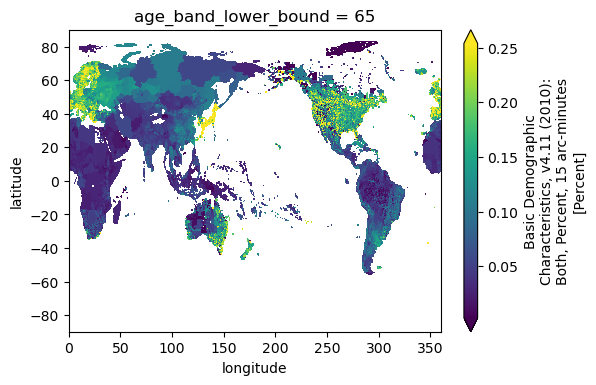

In [38]:
demog_pcts.sel(age_band_lower_bound=65).plot(robust=True)

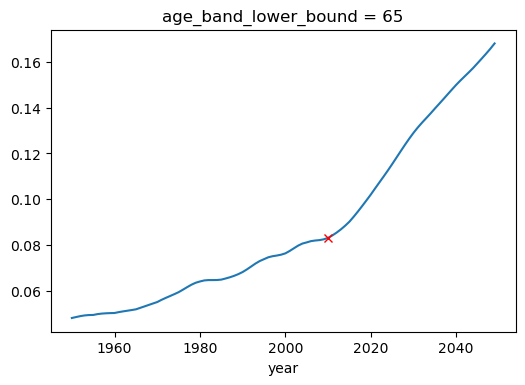

In [39]:
results.sel(age_band_lower_bound=65).mean(dim=['latitude', 'longitude']).plot()
plt.plot([2010], demog_pcts.sel(age_band_lower_bound=65).mean(dim=['latitude', 'longitude']), 'xr')


In [42]:
(results
 .to_dataset(name='demographic_fraction')
 .to_netcdf(POP_DATA_SRC / 'demographics_pct_1950_2050_15_min_era_compat.nc',
            encoding={'demographic_fraction': {'dtype': 'float32'}}
                                                         ))

# Convert percentages to totals using population files

In [43]:
demog_years = results * population

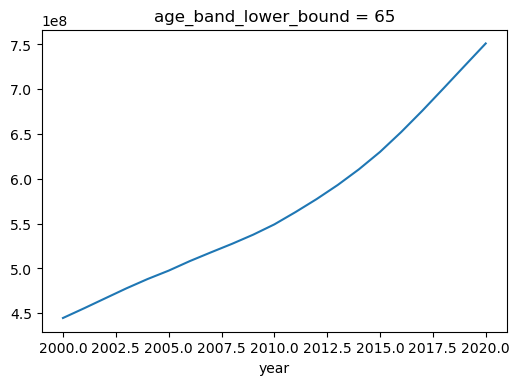

In [44]:
(demog_years.sel(age_band_lower_bound=65).sum(dim=['latitude', 'longitude'])).plot()

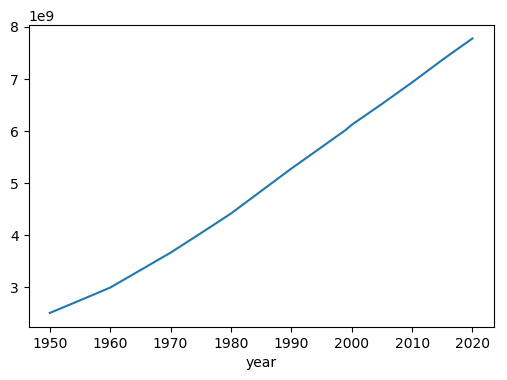

In [38]:
(demog_years.sum(dim=['latitude', 'longitude', 'age_band_lower_bound'])).plot()

In [45]:
(demog_years
 .to_dataset(name='demographic_totals')
 .to_netcdf(POP_DATA_SRC / 'demographics_2000_2020_15_min_era_compat.nc',
            encoding={'demographic_totals': {'dtype': 'float32'}}))

# Try to recover ISIMIP data by upsampling

Basically trying to do a wieghted assignment of the population in the low rez file to the high rez grid

Calculate the population density per grid cell using the GPW cell info, linear interpolate, then re-multiply by the high res grid cells

> **NOTE**: it seems this method works for the ISIMIP part of the data but introduces a systematic error for the GPW (post-2000) part. I think its best to present these together but seperately, can put everything into one file but need to remember to highlight that pre and post 2000 data has different quality.



In [24]:
POPULATION_FILE_LOWREZ = POP_DATA_SRC / 'population_ismip_and_gpw4_era_compat.nc'
AREA_FILE_LOWREZ = POP_DATA_SRC / 'land_mask_30min_era_compat.nc'

In [25]:
area_lowrez = xr.open_dataset(AREA_FILE_LOWREZ)

area_highrez = GPW_DATA['Land and Water Area, v4.11 (2010): Land Area']

population_lowrez = xr.open_dataarray(POPULATION_FILE_LOWREZ)

population_lowrez = population_lowrez.sel(year=slice(1950, None))

In [69]:
pop_per_area = population_lowrez / area_lowrez.land_water_area

In [70]:
# Population density per pixel is constant
pop_per_area = pop_per_area.interp_like(area_highrez)

In [71]:
population_interped = pop_per_area * area_highrez

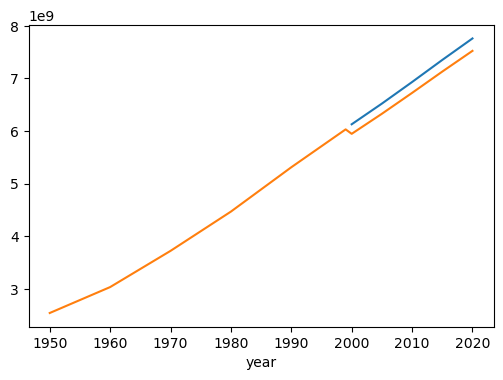

In [73]:
population.sum(dim=['latitude', 'longitude']).plot()
population_interped.sum(dim=['latitude', 'longitude']).plot()

# population_lowrez.sum(dim=['latitude', 'longitude']).plot()


In [74]:
check = np.abs(population - population_interped )

In [80]:
# check.mean(dim=['latitude', 'longitude']).plot()

**Keep only 1950-1999 corresponding to the ISIMIP part, get wierd artefacts when merging with GPW**

In [91]:
population_interped.sel(year=slice(1950, 1999)).to_dataset(name='population').to_netcdf(
    POP_DATA_SRC / 'population_ismip_interp_15_min_era_compat.nc',
    encoding={'population': {'dtype': 'float32'}})

In [92]:
population_combo = xr.concat([population_interped.sel(year=slice(1950, 1999)), population], 'year')

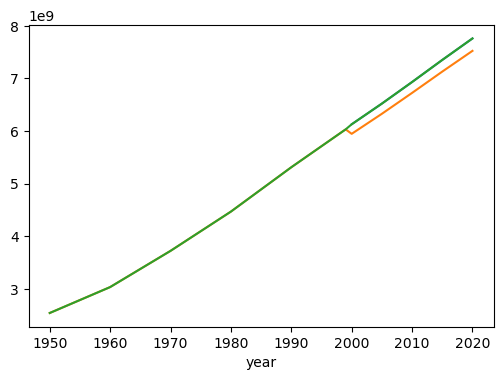

In [93]:
population.sum(dim=['latitude', 'longitude']).plot()
population_interped.sum(dim=['latitude', 'longitude']).plot()
population_combo.sum(dim=['latitude', 'longitude']).plot()\


In [95]:
demographic_fraction = xr.open_dataset(POP_DATA_SRC / 'demographics_pct_1950_2050_15_min_era_compat.nc')

In [97]:
demog_combo_years = demographic_fraction.demographic_fraction * population_combo

In [101]:
(demog_combo_years
 .to_dataset(name='demographic_totals')
 .to_netcdf(POP_DATA_SRC / 'demographics_hybrid_1950_2020_15_min_era_compat.nc',
            encoding={'demographic_totals': {'dtype': 'float32'}}))

# Re-extract the population totals so that we have consistent values

In [11]:
demog_years = xr.open_dataset(POP_DATA_SRC / 'demographics_2000_2020_15_min_era_compat.nc')

In [12]:
demog_years

<xarray.Dataset>
Dimensions:               (age_band_lower_bound: 14, latitude: 290, longitude: 720, year: 71)
Coordinates:
  * latitude              (latitude) float64 85.0 84.5 84.0 ... -59.0 -59.5
  * year                  (year) int64 1950 1951 1952 1953 ... 2018 2019 2020
  * longitude             (longitude) float64 0.0 0.5 1.0 ... 358.5 359.0 359.5
  * age_band_lower_bound  (age_band_lower_bound) int64 0 5 10 15 ... 50 55 60 65
Data variables:
    demographic_totals    (latitude, longitude, age_band_lower_bound, year) float64 ...

In [15]:
totals = []
    
for _, row in tqdm(COUNTRIES_LOOKUP.iterrows(), total=len(COUNTRIES_LOOKUP)):
    grid_code = row.GRIDCODE
    country_mask = COUNTRIES_RASTER.country_codes == grid_code

    pop_total = (demog_years.demographic_totals * country_mask).sum(dim=['latitude', 'longitude', 'age_band_lower_bound'])

    totals.append(pop_total.to_dataframe(row.ISOCODE))

totals = pd.concat(totals, axis=1)

100%|██████████| 248/248 [07:01<00:00,  1.70s/it]


In [18]:
tmp = totals[totals >0]

In [21]:
tmp = tmp.stack().reset_index()
tmp.columns = ['year', 'iso3_code', 'population']

# tmp.sort_values(['iso3_code', 'year'])

year iso3_code    population
10588  2000       ABW  5.993143e+04
10820  2001       ABW  6.138452e+04
11052  2002       ABW  6.283398e+04
11284  2003       ABW  6.427886e+04
11516  2004       ABW  6.571862e+04
...     ...       ...           ...
14351  2016       ZWE  1.619312e+07
14583  2017       ZWE  1.658637e+07
14815  2018       ZWE  1.697834e+07
15047  2019       ZWE  1.736789e+07
15279  2020       ZWE  1.775469e+07

[15322 rows x 3 columns]

In [23]:
tmp = tmp.sort_values(['iso3_code', 'year'])[['iso3_code','year',  'population']]

In [25]:
tmp.to_csv('population_by_country.csv', index=False)